#**House Price Prediction**


In [37]:
#testing GPU is enable
import tensorflow as tf
tf.test.gpu_device_name()

''

In [38]:
#import Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

import time
import datetime

##Global functions and variables 

In [6]:
FETCH_UPDATED = False

_folder_dir= '/content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/'
_dataset = 'housing'
_dataset2 = 'housing_updated_bedrooms'

_ds_report = 'report'
_pickle = 'loc_update_3'



In [7]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    perc = value/max*100
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
        <h1> {perc}% </h1>
    """.format(value=value, max=max,perc=perc))

##Fetch Dataset

In [39]:
#fetch data set

ds_dir = _folder_dir+_dataset+('_updated' if FETCH_UPDATED else '') + '.csv'
#df = pd.read_csv (r'/content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/housing.csv')
# df = pd.read_csv (ds_dir)

df = pd.read_csv (_folder_dir+_dataset2+'.csv')




###Dataset Status

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.info()

## Initial Data Analytics 

In [22]:
!pip install sweetviz

     |████████████████████████████████| 15.1 MB 4.7 MB/s 


In [23]:
import sweetviz as sv

In [24]:


report = sv.analyze(df)

report.show_html(_folder_dir + _ds_report + '.html')

                                             |          | [  0%]   00:00 -> (? left)

Report /content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


##Data Pre-Proccessing 




In [97]:
from geopy.geocoders import Nominatim
import pickle

###Exmples

In [103]:
## Feature Engineering


geolocator = Nominatim(user_agent = 'geoapiExercices')


In [104]:
#geolocator example
geolocator.reverse("37.88"+","+ "-122.23")[0]
geolocator.reverse("37.88"+","+ "-122.23").raw['address']

{'city': 'Oakland',
 'country': 'United States',
 'country_code': 'us',
 'county': 'Alameda County',
 'leisure': 'Ecological Study Area',
 'postcode': '94563',
 'road': 'Upper Side Hill entrance',
 'state': 'California'}

### Generate a pickle file

In [49]:
#get raw address given a latetude and longatude cord

loc_update = {
    "County":[],
    "Road":[]
}

def location(cord):
  long = str(cord[0])
  lat = str(cord[1])
  #print(cord)
  location = geolocator.reverse(lat + "," + long).raw['address'] # dictiomary
  # print(location)
  
  #replace the missing places
  if location.get('road') is None:
    location['road'] = None

  if location.get('county') is None:
    location['county'] = None

  #print(location["road"])
  loc_update['Road'].append(location['road'])

  loc_update['County'].append(location['county'])



In [50]:
#print(df.iloc[:,0:2])
import time

start = time.time()

out = display(progress(0, df.shape[0]), display_id=True)


for i,cord in enumerate(df.iloc[:,0:2].values):
  location(cord)

  pickle.dump(loc_update,open('/content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/loc_update_3.pickle','wb'))
  out.update(progress(i, df.shape[0]))

  # if i%100 == 5:
  #   print(str((i/df.shape[0])*100)+"%")
  #   break

stop = time.time()
print('Time: ', stop - start," Sec")  
print("Done")

NameError: ignored

In [ ]:
#the time that toked to get updated location (generate loc_update.pickle)
print(i)
import datetime
t_sec  = 10322.550931215286
str(datetime.timedelta(seconds=t_sec))


### Load a pickle file

In [98]:
#load a pickle module
loc_update2 = pickle.load(open(_folder_dir + _pickle + '.pickle' ,"rb"))
# loc = pd.DataFrame(loc_update2)



In [99]:
# add new features to dataframe
for feature in loc_update2.keys():
  df[feature] = loc_update2[feature]

df = df.sample(axis=0,frac=1) #to random


###Dataset Status

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


##Using calssification algo to fill the missing values


In [270]:
from sklearn.linear_model import SGDClassifier
import time,datetime

In [271]:


def creat_in_dependent_features():
  global miss_X_train ,miss_y_train,miss_X_test, miss_y_pred

  #independent features
  miss_X_train = np.array([[df['total_rooms'][i],df['households'][i],df['median_income'][i]] for i in range(df.shape[0])if i not in miss_idx])
  miss_y_train = np.array([df[_feature_][i] for i in range(df.shape[0])if i not in miss_idx])

  miss_X_test = np.array([[df['total_rooms'][i],df['households'][i],df['median_income'][i]] for i in range(df.shape[0])if i in miss_idx])

def init_feature_model():
  global SGD_model

  # init model 
  s = time.time()
  SGD_model = SGDClassifier() #(verbose=1)
  print("Feature '{}': Init model done. time={}".format(_feature_, str(datetime.timedelta(seconds=time.time()-s))))

def train_feature_mode():
  global SGD_model ,miss_X_train ,miss_y_train,miss_X_test, miss_y_pred

  #model training
  s = time.time()
  SGD_model.fit(miss_X_train,miss_y_train)
  print("Feature '{}': Training done. time={}".format(_feature_, str(datetime.timedelta(seconds=time.time() -s ))))

def predict_feature_mode():
  global SGD_model ,miss_X_train ,miss_y_train,miss_X_test, miss_y_pred

  #predict
  s = time.time()
  miss_y_pred = SGD_model.predict(miss_X_test)
  print("Feature '{}': Prediction done. time={}".format(_feature_, str(datetime.timedelta(seconds= time.time() -s))))

def update_feature_bak_to_dataframe():
  global SGD_model ,miss_X_train ,miss_y_train,miss_X_test, miss_y_pred

  #add the missing values back to dataframe
  for n,i in enumerate(miss_idx):
    df[_feature_][i] = miss_y_pred[n]

### Road feature

In [102]:
#appling Logistic algo 

_feature_ = 'Road'
miss_idx = []
for i in range(df.shape[0]):
  if df[_feature_][i] is None:
    miss_idx.append(i)

creat_in_dependent_features()

init_feature_model()
train_feature_mode()
predict_feature_mode()

update_feature_bak_to_dataframe()


Feature 'Road': Init model done. time=0:00:00.000036
Feature 'Road': Training done. time=0:04:51.912462
Feature 'Road': Prediction done. time=0:00:00.064151


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


###County

In [272]:
#appling Logistic algo 
_feature_ = 'County'
miss_idx = []
for i in range(df.shape[0]):
  if df[_feature_][i] is None:
    miss_idx.append(i)

creat_in_dependent_features()

init_feature_model()
train_feature_mode()
predict_feature_mode()

update_feature_bak_to_dataframe()


KeyError: ignored

###total_bedrooms Feature

In [273]:
#appling Logistic algo 
_feature_ = 'total_bedrooms'

miss_idx = []
for index, row in df[df[_feature_].isnull()].iterrows():
  miss_idx.append(index)


creat_in_dependent_features()

init_feature_model()
train_feature_mode()
predict_feature_mode()

update_feature_bak_to_dataframe()



Feature 'total_bedrooms': Init model done. time=0:00:00.000035
Feature 'total_bedrooms': Training done. time=0:01:27.398662
Feature 'total_bedrooms': Prediction done. time=0:00:00.005009


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Dataframe Status

In [274]:
# no data missing in our data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


###Save data fram to updated .csv file



In [275]:
df.to_csv(_folder_dir + _dataset + '_updated' + '.csv',index=False)

df5 = pd.read_csv (_folder_dir + _dataset + '_updated' + '.csv')
df5.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


##Labels Encoding

In [40]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


In [184]:
#encode label features 
# from sklearn.preprocessing import LabelEncoder

df['Road'] = le.fit_transform(df['Road'])

In [41]:
#encode label features ocean_proximity

df['ocean_proximity'] = le.fit_transform(df['ocean_proximity'])

In [186]:
df['County'] = le.fit_transform(df['County'])

In [389]:
#the dataframe now have a categorical values
#not a string format (label encoding)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3


##Final Data analysis 

###Numerical columns data analysis

<Figure size 360x360 with 0 Axes>

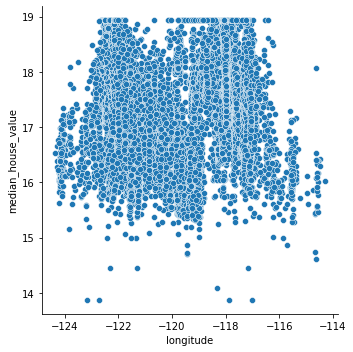

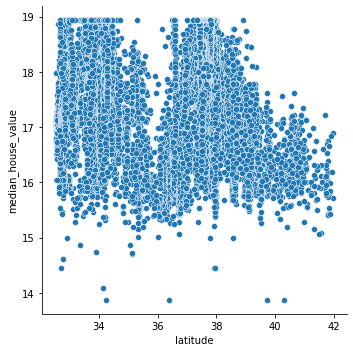

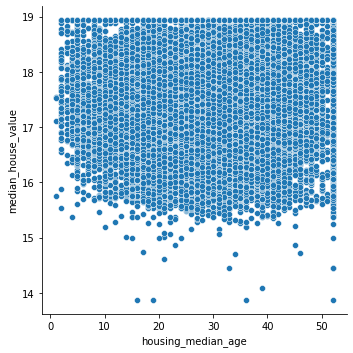

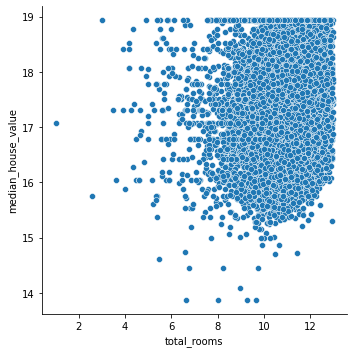

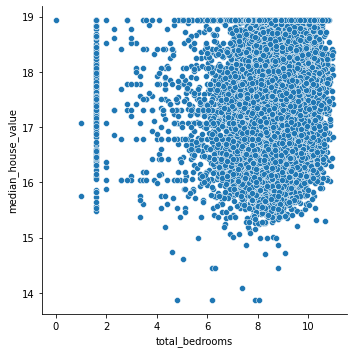

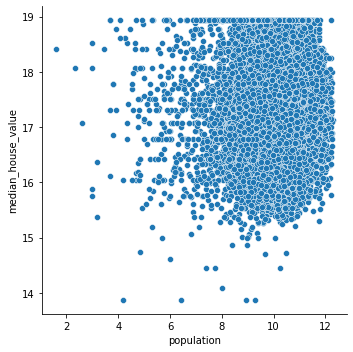

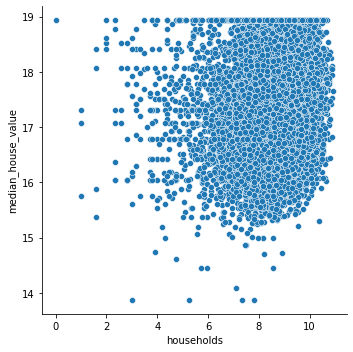

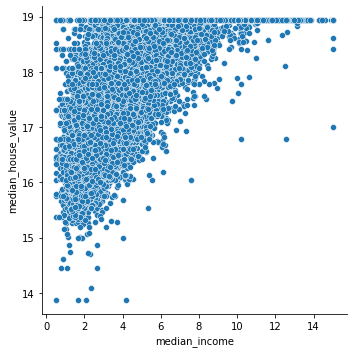

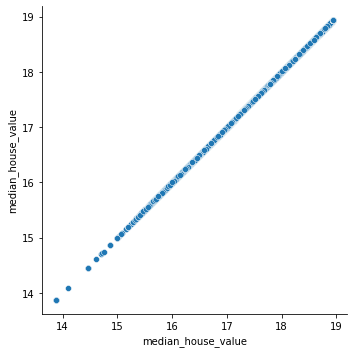

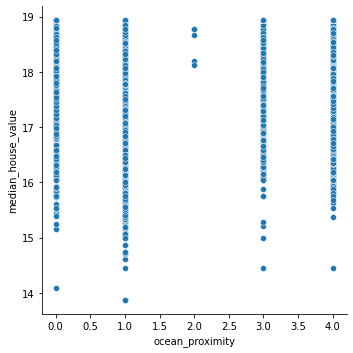

In [44]:
import seaborn as sns

y = df['median_house_value']

for idx, col in enumerate(df.columns):
    plt.ylabel = 'median_house_value'
    plt.figure(idx, figsize=(5,5))
    sns.relplot(x=col, y=y, kind="scatter", data=df)
    plt.show

### Reports

In [140]:
report = sv.analyze(df)

report.show_html(_folder_dir +'reports/' +_ds_report +'_full' + '.html')

                                             |          | [  0%]   00:00 -> (? left)

Report /content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/reports/report_full.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


##Feature Engineering 

### Remove longitude	latitude features

In [348]:
#drop latitude and londitude

df = df.drop(labels=["longitude",	"latitude"],axis=1) # to remove columns
df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3


### Logarithm features

In [43]:
df['median_house_value'] = np.log2(df['median_house_value'])
df['households'] = np.log2(df['households'])
df['population'] = np.log2(df['population'])
df['total_rooms'] = np.log2(df['total_rooms'])
df['total_bedrooms'] = np.log2(df['total_bedrooms'])



### Clean up features values

In [42]:
#clean rows
#remove rows
df.drop(df[df['total_rooms'] >= 8000].index, inplace = True)
df.drop(df[df['total_bedrooms'] > 2000].index, inplace = True)
df.drop(df[df['population'] >= 5000].index, inplace = True)
# df.drop(df[df['median_house_value'] >= 480000].index, inplace = True)



In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20033 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20033 non-null  float64
 1   latitude            20033 non-null  float64
 2   housing_median_age  20033 non-null  float64
 3   total_rooms         20033 non-null  float64
 4   total_bedrooms      20033 non-null  float64
 5   population          20033 non-null  float64
 6   households          20033 non-null  float64
 7   median_income       20033 non-null  float64
 8   median_house_value  20033 non-null  float64
 9   ocean_proximity     20033 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 1.7 MB


In [15]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,9.781360,7.011227,8.330917,6.977280,8.3252,18.787877,3
1,-122.22,37.86,21.0,12.793400,10.111136,11.229420,10.152285,8.3014,18.451614,3
2,-122.24,37.85,52.0,10.518653,7.569856,8.954196,7.467606,7.2574,18.425626,3
3,-122.25,37.85,52.0,10.315150,7.876517,9.124121,7.774787,5.6431,18.380681,3
4,-122.25,37.85,52.0,10.667999,8.129283,9.142107,8.016808,3.8462,18.384480,3


## Training Model


### Prepare data set

In [17]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,9.781360,7.011227,8.330917,6.977280,8.3252,18.787877,3
1,-122.22,37.86,21.0,12.793400,10.111136,11.229420,10.152285,8.3014,18.451614,3
2,-122.24,37.85,52.0,10.518653,7.569856,8.954196,7.467606,7.2574,18.425626,3
3,-122.25,37.85,52.0,10.315150,7.876517,9.124121,7.774787,5.6431,18.380681,3
4,-122.25,37.85,52.0,10.667999,8.129283,9.142107,8.016808,3.8462,18.384480,3


In [18]:
#dependent feature
if FETCH_UPDATED:
  y = df.iloc[:,-4].values # price median_house_value with road and county
else:
  y = df.iloc[:,-2].values # price median_house_value with road and county


In [19]:
#independent value
df.drop(labels=['median_house_value'],axis = 1,inplace=True)


In [20]:

X = df.iloc[:,:].values

In [21]:
from sklearn.model_selection import train_test_split

# train_test_split?
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20033 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20033 non-null  float64
 1   latitude            20033 non-null  float64
 2   housing_median_age  20033 non-null  float64
 3   total_rooms         20033 non-null  float64
 4   total_bedrooms      20033 non-null  float64
 5   population          20033 non-null  float64
 6   households          20033 non-null  float64
 7   median_income       20033 non-null  float64
 8   ocean_proximity     20033 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.5 MB


### Report training set 

In [23]:
import sweetviz as sv

compare_report = sv.compare([pd.DataFrame(data=X_train,columns=df.columns), 'Train'], [pd.DataFrame(data=X_test,columns=df.columns), 'Test'])
compare_report.show_html(_folder_dir + 'reports/'+ 'compare_Train_Test_set.html', open_browser=False)

ModuleNotFoundError: ignored

### Random Forest model

In [28]:
#random forest
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor()

s = time.time()
random_forest_model.fit(X_train,y_train)
print("training done. time={}".format(str(datetime.timedelta(seconds=time.time() -s ))))

training done. time=0:00:10.403289


In [29]:
#model prediction, verefication

y_pred = random_forest_model.predict(X_test)

In [35]:
#model accuracy
from sklearn.metrics import r2_score

r2_score(y_test,y_pred)*100


83.60338072746258

#### Comparing Test/Predictions reports

In [ ]:

compare_report = sv.compare([pd.DataFrame(y_test), 'True Value'], [pd.DataFrame(y_pred), 'Predicted Value'])
compare_report.show_html(_folder_dir + 'reports/' 'compare_test_with_predicted.html', open_browser=False)

### Linear Regression

In [150]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

s = time.time()
linear_model.fit(X_train,y_train)
print("training done. time={}".format(str(datetime.timedelta(seconds=time.time() -s ))))


training done. time=0:00:00.039025


In [151]:
#model prediction, verefication

y_pred = linear_model.predict(X_test)

In [152]:
#model accuracy
from sklearn.metrics import r2_score

r2_score(y_test,y_pred)*100

55.590183780834415

##Add our own data

In [153]:
#452600.0
#inp = np.array([-122.23,	37.88,	41.0,	880.0	,129.0,	322.0	,126.0	,8.3252	,	3])

#186200.0
# inp = np.array([32.0	,1605.0,	314.0	,986.0,	306.0	,3.3375,		0	,1	,5387])

#232400.0
inp = np.array([-122.41	,37.65	,32.0	,3436.0,	868.0	,2583.0,	817.0,	3.5039	,	4	,43,	6890])


inp

array([-1.2241e+02,  3.7650e+01,  3.2000e+01,  3.4360e+03,  8.6800e+02,
        2.5830e+03,  8.1700e+02,  3.5039e+00,  4.0000e+00,  4.3000e+01,
        6.8900e+03])

In [154]:
ip = inp.reshape((1,-1))
ip

array([[-1.2241e+02,  3.7650e+01,  3.2000e+01,  3.4360e+03,  8.6800e+02,
         2.5830e+03,  8.1700e+02,  3.5039e+00,  4.0000e+00,  4.3000e+01,
         6.8900e+03]])

In [155]:
random_forest_model.predict(ip)

ValueError: ignored

In [ ]:
linear_model.predict(ip)